# Trying to figure out consistent log binning

In [14]:
from __future__ import annotations

# Setup
import logging
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import pachyderm.plot as pb
from mammoth import helpers as mammoth_helpers
from mammoth.eec.plot import exploration

%load_ext autoreload
%autoreload 2

%matplotlib widget
%config InlineBackend.figure_formats = ["png", "pdf"]
# Don't show mpl images inline. We'll handle displaying them separately.
#plt.ioff()
# Ensure the axes are legible on a dark background
#mpl.rcParams['figure.facecolor'] = 'w'

mammoth_helpers.setup_logging(level=logging.DEBUG)
# Quiet down the matplotlib logging
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("pachyderm.histogram").setLevel(logging.INFO)
logging.getLogger("boost_histogram").setLevel(logging.INFO)
logging.getLogger("numba").setLevel(logging.INFO)
logging.getLogger("Comm").setLevel(logging.INFO)

logger = logging.getLogger(__name__)

# General settings
embed_images = False
base_dir = Path("projects/exploration")
output_dir = base_dir / Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np

import hist

In [201]:
rng = np.random.default_rng(42)
#data = rng.poisson(50, 10000) / 20
data = np.random.rand(10000) * 20
# Keep strictly positive values
data = data[data > 0]
len(data)

10000

In [48]:
linear_axis_args = 0, 100, 101
log_axis_args = 1e-2, 100, 101
logspace_axis_args = (-2, 2, 101)

In [6]:
print(*linear_axis_args[:-1], linear_axis_args[-1] - 1)

0 100 100


In [65]:
log_axis_manual = np.logspace(*logspace_axis_args)
lin_data = hist.Hist(hist.axis.Regular(linear_axis_args[-1] - 1, *linear_axis_args[:-1], )).fill(data)
log_fill_data = hist.Hist(hist.axis.Regular(linear_axis_args[-1] - 1, *linear_axis_args[:-1], )).fill(np.log(data))
log_data = hist.Hist(hist.axis.Regular(log_axis_args[-1] - 1, *log_axis_args[:-1], transform=hist.axis.transform.log)).fill(data)
log_data_manual_axis = hist.Hist(hist.axis.Variable(log_axis_manual)).fill(data)

/var/folders/s4/zc_9tsr13mvbdxfpt284svpm0000gp/T/ipykernel_5069/4169752893.py:3: RuntimeWarning: divide by zero encountered in log
  log_fill_data = hist.Hist(hist.axis.Regular(linear_axis_args[-1] - 1, *linear_axis_args[:-1], )).fill(np.log(data))


In [56]:
np.isclose(log_data_manual_axis.axes[0].centers, log_data.axes[0].centers, atol=0.1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [24]:
import mplhep as hep
from pachyderm import binned_data

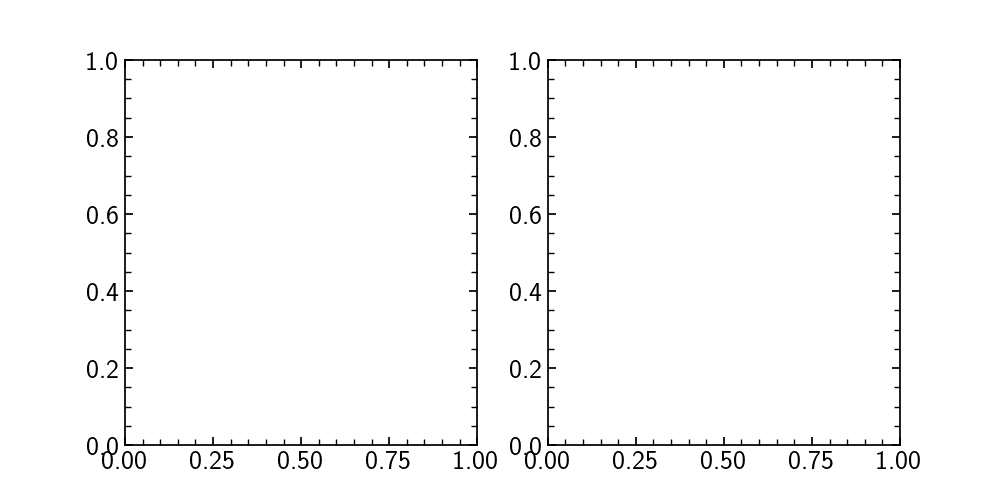

In [153]:
plt.close()
fig, (ax, ax_log) = plt.subplots(1, 2, figsize=(10, 5))

In [25]:
h_lin_data = binned_data.BinnedData.from_existing_data(lin_data)
ax.errorbar(
    h_lin_data.axes[0].bin_centers,
    h_lin_data.values,
)
fig

AttributeError: 'numpy.ndarray' object has no attribute 'value'

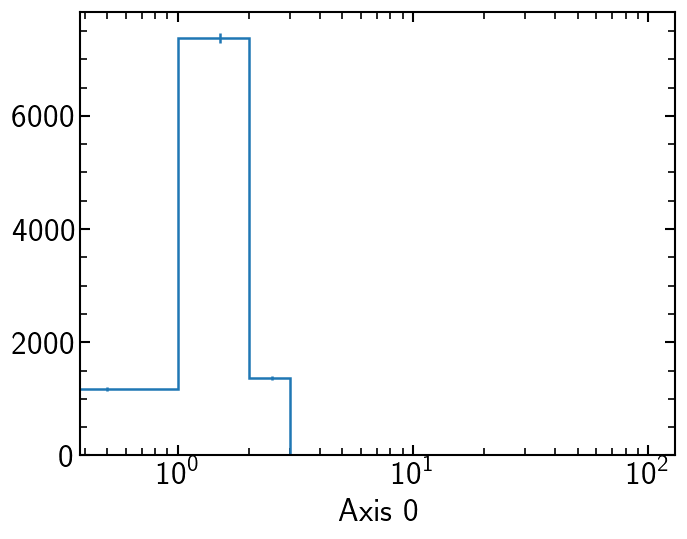

In [70]:
hep.histplot(log_fill_data)
ax.set_xscale("log")
fig

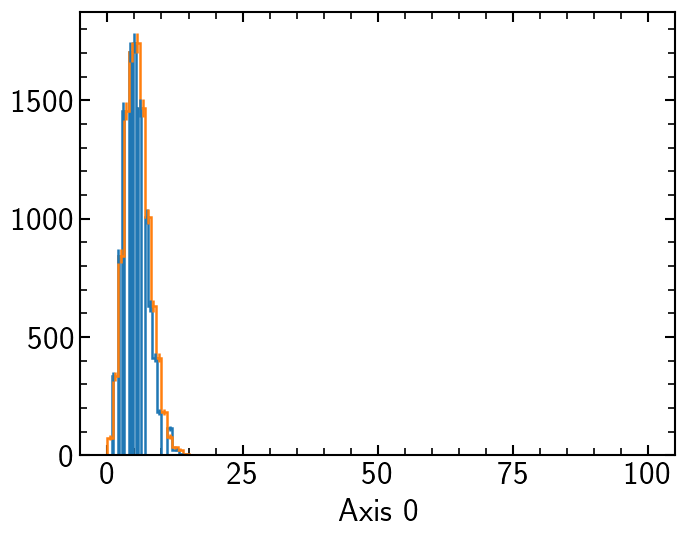

In [28]:
hep.histplot(lin_data)
fig

In [35]:
hep.histplot(log_data_manual_axis)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x2a19bc050>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

In [99]:
# Rough bins from the STAR plot
star_bins = np.logspace(-2, 3, 11, base=np.exp(1))
# These are fully equivalent. Instead, we generate them in linear space, and then transform them
star_bins_2 = np.exp(np.linspace(-2, 3, 11, endpoint=True))
assert np.allclose(star_bins, star_bins_2)

In [238]:
star_bins

array([ 0.13533528,  0.22313016,  0.36787944,  0.60653066,  1.        ,
        1.64872127,  2.71828183,  4.48168907,  7.3890561 , 12.18249396,
       20.08553692])

In [252]:
h_star_linear = hist.Hist(hist.axis.Regular(10, 0, 20)).fill(data)
#h_star_log = hist.Hist(hist.axis.Variable(star_bins)).fill(np.log(data))
h_star_log = hist.Hist(hist.axis.Variable(star_bins)).fill(data)
h_star_log_via_hist = hist.Hist(hist.axis.Regular(10, np.exp(-2), np.exp(3), transform=hist.axis.transform.log)).fill(data)
h_star_dumb_log = hist.Hist(hist.axis.Regular(10, -2, 3)).fill(np.log(data))

In [243]:
h_star_log

Hist(Variable([0.135335, 0.22313, 0.367879, 0.606531, 1, 1.64872, 2.71828, 4.48169, 7.38906, 12.1825, 20.0855], label='Axis 0'), storage=Double()) # Sum: 9934.0 (10000.0 with flow)

In [254]:
h_star_dumb_log.axes[0].edges

array([-2.00000000e+00, -1.50000000e+00, -1.00000000e+00, -5.00000000e-01,
        2.22044605e-16,  5.00000000e-01,  1.00000000e+00,  1.50000000e+00,
        2.00000000e+00,  2.50000000e+00,  3.00000000e+00])

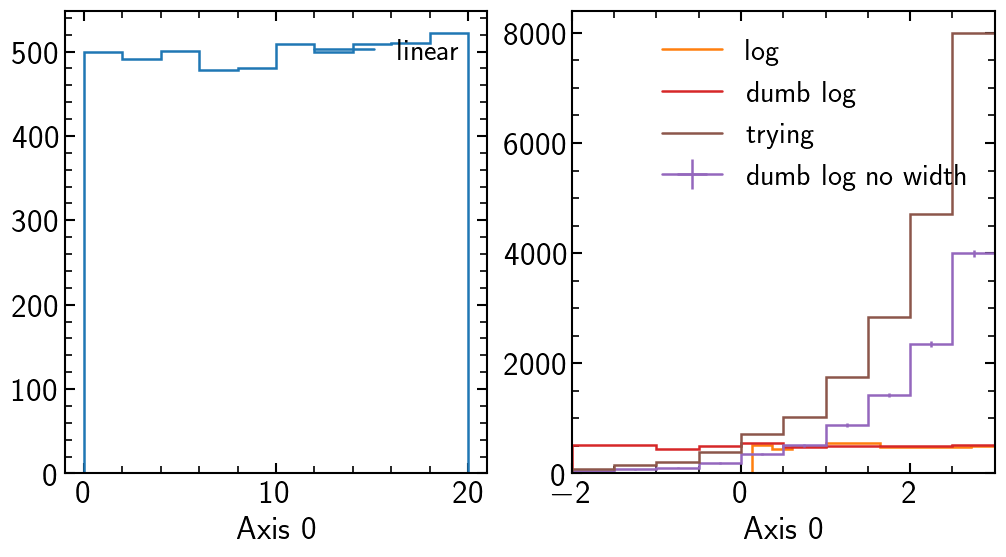

In [253]:
ax.clear(), ax_log.clear()
hep.histplot(h_star_linear / h_star_linear.axes[0].widths, ax=ax, label="linear", color="C0")
hep.histplot(h_star_log / h_star_log.axes[0].widths, ax=ax_log, label="log", color="C1")
#hep.histplot(h_star_log_via_hist / h_star_log_via_hist.axes[0].widths, ax=ax_log, label="log via hist", color="C2")
hep.histplot(h_star_dumb_log / np.exp(h_star_dumb_log.axes[0].centers) / h_star_dumb_log.axes[0].widths, ax=ax_log, label="dumb log", color="C3")
hep.histplot(h_star_dumb_log, ax=ax_log, label="dumb log no width", color="C4")
hep.histplot(h_star_dumb_log / h_star_dumb_log.axes[0].widths, ax=ax_log, label="trying", color="C5")
ax.legend(loc="upper right", frameon=False), ax_log.legend(loc="upper right", frameon=False)
ax_log.set_xlim(-2, 3)
#ax_log.set_xscale("log")
#ax_log.set_ylim(1e-2, 1e3)
fig

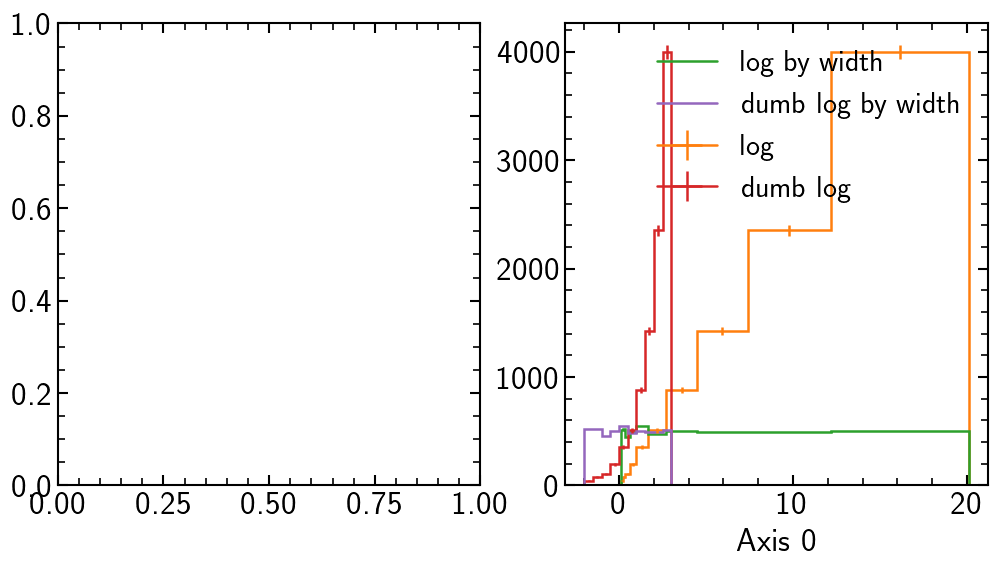

In [267]:
ax.clear(), ax_log.clear()
hep.histplot(h_star_log, ax=ax_log, label="log", color="C1")
hep.histplot(h_star_log / h_star_log.axes[0].widths, ax=ax_log, label="log by width", color="C2")
hep.histplot(h_star_dumb_log, ax=ax_log, label="dumb log", color="C3")
hep.histplot(h_star_dumb_log / (h_star_dumb_log.axes[0].widths * np.exp(h_star_dumb_log.axes[0].centers)), ax=ax_log, label="dumb log by width", color="C4")
ax_log.legend(loc="upper right", frameon=False)
fig

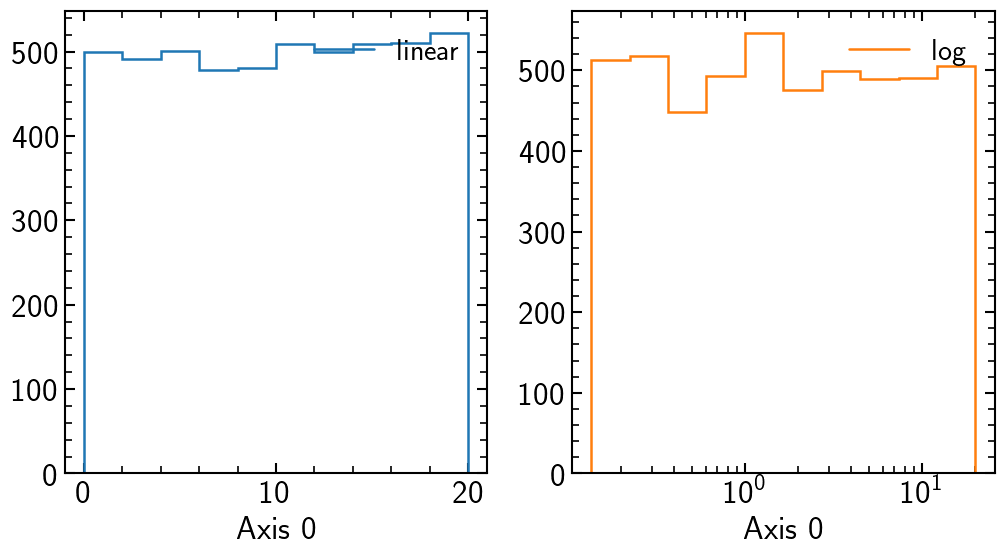

In [246]:
ax.clear(), ax_log.clear()
hep.histplot(h_star_linear / h_star_linear.axes[0].widths, ax=ax, label="linear", color="C0")
hep.histplot(h_star_log / h_star_log.axes[0].widths, ax=ax_log, label="log", color="C1")
ax.legend(loc="upper right", frameon=False), ax_log.legend(loc="upper right", frameon=False)
#ax_log.set_xlim(-2, 3)
#oax_log.set_xscale("log", base=np.exp(1))
ax_log.set_xscale("log")
#ax_log.set_ylim(1e-2, 1e3)
fig

In [179]:
np.count_nonzero(data < 0.22) / len(data)

0.0096

In [220]:
h_star_dumb_log.axes[0].centers, h_star_log.view()

(array([-1.75, -1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25,
         2.75]),
 array([  67.,   91.,  191.,  423., 1223., 4904., 2524.,    0.,    0.,
           0.]))

In [172]:
hist.axis.Regular(10, 0, 10, transform=hist.axis.transform.sqrt).edges, hist.axis.Regular(10, 0, 10).edges

(array([ 0. ,  0.1,  0.4,  0.9,  1.6,  2.5,  3.6,  4.9,  6.4,  8.1, 10. ]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [174]:
hist.axis.Regular(10, np.exp(-2), np.exp(3), transform=hist.axis.transform.log).edges, hist.axis.Regular(10, -2, 3).edges

(array([ 0.13533528,  0.22313016,  0.36787944,  0.60653066,  1.        ,
         1.64872127,  2.71828183,  4.48168907,  7.3890561 , 12.18249396,
        20.08553692]),
 array([-2.00000000e+00, -1.50000000e+00, -1.00000000e+00, -5.00000000e-01,
         2.22044605e-16,  5.00000000e-01,  1.00000000e+00,  1.50000000e+00,
         2.00000000e+00,  2.50000000e+00,  3.00000000e+00]))

In [176]:
star_bins

array([ 0.13533528,  0.22313016,  0.36787944,  0.60653066,  1.        ,
        1.64872127,  2.71828183,  4.48168907,  7.3890561 , 12.18249396,
       20.08553692])

In [205]:
hist.axis.Regular(30, 1, 500, transform=hist.axis.transform.log).centers

array([  1.10913097,   1.36442133,   1.67847226,   2.06480876,
         2.54006892,   3.12472043,   3.84394207,   4.72870805,
         5.81712194,   7.15605772,   8.80317837,  10.82941928,
        13.32204312,  16.38839798,  20.16054038,  24.80092252,
        30.50938845,  37.53178063,  46.17052746,  56.79766774,
        69.87087301,  85.95315775, 105.73712634, 130.07480098,
       160.01431506, 196.84505249, 242.15317657, 297.88994024,
       366.45571928, 450.8033876 ])

In [207]:
np.log(data).min(), np.log(data).max()

(-6.7094271362409845, 2.9957010834898705)